In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Uncomment the next two lines if running for the book
# import warnings
# warnings.filterwarnings("ignore")

# The Karhunen-Loève Expansion of a Gaussian Process

If you want to know more about the Karhunen-Loève expansion, you can check the following references:

+ Betz, W., Papaioannou, I., & Straub, D. (2014). Numerical methods for the discretization of random fields by means of the Karhunen-Loeve expansion. Computer Methods in Applied Mechanics and Engineering, 271, 109-129. doi:10.1016/j.cma.2013.12.010

## Karhunen-Loeve Expansion

Consider a Gaussian process:

$$
f \sim \operatorname{GP}\left(m, k \right),
$$

where 
$m$ is the mean function and $k$ is the covariance function.
The *Karhunen-Loève expansion* (KLE) of $f$ allows us to write it as:

$$
f(\mathbf{x}) = m(\mathbf{x}) + \sum_{i=1}^{\infty}\xi_i \sqrt{\lambda_i} \phi_i(\mathbf{x}),
$$

where the random variables

$$
\xi_i \sim \mathcal{N}(0, 1)
$$

are independent, and $\lambda_i$ and $\phi_i(\mathbf{x})$ are the eigenvalues and
eigenvectors, respectively, of the covariance function, i.e.,

$$
\int k(\mathbf{x}, \mathbf{x}') \phi_i(\mathbf{x}')d\mathbf{x}' = \lambda_i \phi_i(\mathbf{x}').
$$

Since $k(\cdot, \cdot)$ is actually positive definite, the eigenvalues are all positive
and the eigenfunctions are orthogonal:

$$
\int \phi_i(\mathbf{x})\phi_j(\mathbf{x}')d\mathbf{x} = \delta_{ij}.
$$

### Truncated KLE
Usually, we truncate the KLE to a finite order $M$, i.e., we write

$$
\begin{equation}
f(\mathbf{x}) \approx f_M(\mathbf{x}) = m(\mathbf{x}) + \sum_{i=1}^M \xi_i \sqrt{\lambda_i}\phi_i(\mathbf{x}).
\end{equation}
$$

But how do we pick $M$ in practice?

In order to answer this question, notice that the variance of the field at the point $\mathbf{x}$ is given by:

$$
\mathbb{V}[f(\mathbf{x})] = \sum_{i=1}^{\infty}\lambda_i\phi_i^2(\mathbf{x})
$$

The *energy* of the field, $\mathcal{E}[f(\cdot)]$ is defined to be:

$$
\mathcal{E}[f] := \int\mathbb{V}[f(\mathbf{x})]d\mathbf{x} = \sum_{i=1}^\infty \lambda_i,
$$

where we have used the orthonormality of the $\phi_i$'s.
The energy of the field is a measure of the total variance of the field.
The idea is to select $M$ so that the energy of the truncated field $f_M$
captures a percentage $\alpha$ of the energy of the original field.
That is, we pick $M$ so that

$$
\mathcal{E}[f_M] = \alpha\mathcal{E}[f],
$$

or

$$
\sum_{i=1}^M\lambda_i = \alpha \sum_{i=1}^\infty \lambda_i.
$$

Typically, $\alpha = 0.95$.

### Why is this useful?
The KLE allows us to reduce the dimensionality of random fields.
This is extremely useful in uncertainty propagation and model calibration tasks.
For example, in uncertainty propagation, by employing the KLE one has to deal with
a finite set of Gaussian random variables $\xi_i$ instead of an infinitely dimensional
Gaussian random field.

Here is an implementation of the Karhunen-Loève expansion in JAX using tinygp:

In [2]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
from tinygp import GaussianProcess, kernels
from jaxtyping import Array, Float

jax.config.update("jax_enable_x64", True)
key = jrandom.key(0)

In [3]:
class KarhunenLoeveExpansion(eqx.Module):
    """
    The Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Parameters
    ----------
    gp : tinygp.GaussianProcess
        The Gaussian process to expand.
    wq : Float[Array, "n_q"]
        The quadrature weights.
    alpha : float
        The percentage of the energy of the field that you want to keep.
    """
    gp: GaussianProcess
    lambd: Float[Array, "n_xi"]
    v: Float[Array, "n_xi n_q"]
    wq: Float[Array, "n_q"]
    
    def __init__(self, gp, wq, alpha=0.9):
        # Get the covariance (evaluated at the quadrature points).
        # If our gp is conditioned on some observations, then this will be the posterior covariance.
        Kq = gp.covariance

        # Get the eigenvalues/eigenvectors of the discretized covariance function
        B = jnp.einsum('ij,j->ij', Kq, wq)
        lam, v = jax.scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam = lam.at[lam <= 0.].set(0.)

        # Keep only the eigenvalues that explain alpha% of the energy
        energy = jnp.cumsum(lam) / jnp.sum(lam)
        i_end = jnp.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        
        self.gp = gp
        self.lambd = lam
        self.v = v
        self.wq = wq
    
    @property
    def energy(self):
        """The energy captured by the truncated expansion."""
        return jnp.sum(self.lambd)
    
    @property
    def num_xi(self):
        """The number of terms kept in the truncated expansion."""
        return self.lambd.shape[0]
    
    def eval_phi(self, x):
        """Evaluate the eigenfunctions at x."""
        Kc = self.gp.kernel(x, self.gp.X)  # Evaluate the cross-covariance between the query points (x) and the quadrature points (self.gp.X)
        phi = jnp.einsum("i,ji,j,rj->ri", 1/self.lambd, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """Evaluate the expansion at x and xi."""
        phi = self.eval_phi(x)
        return vmap(self.gp.mean_function)(x) + jnp.dot(phi, xi*self.lambd**0.5)

And here is a convenience function that builds the KLE:

In [4]:
def build_kle(
    k, 
    nq=100, 
    alpha=0.9, 
    Xq=None, 
    wq=None, 
    Xobs=None, 
    yobs=None, 
    *, 
    input_dim
):
    """Build the Karhunen-Loève expansion of a Gaussian process.
    
    Parameters
    ----------
    k : tinygp.kernels.Kernel
        The kernel of the Gaussian process.
    nq : int
        The number of quadrature points.
    alpha : float
        The percentage of the energy of the field that you want the expansion to capture.
        This determines the number of terms in the expansion.
    Xq : jnp.ndarray
        The quadrature points.
    wq : jnp.ndarray
        The quadrature weights
    Xobs : jnp.ndarray
        The observed points.
    yobs : jnp.ndarray
        The observed values.
    input_dim : int
        The dimension of the input space.
    
    Returns
    -------
    kle : KarhunenLoeveExpansion
        The Karhunen-Loève expansion of the Gaussian process.
    """
    # Generate quadrature points
    if Xq is None:
        if input_dim == 1:
            Xq = jnp.linspace(0, 1, nq)[:, None]
            wq = jnp.ones((nq,))/nq
        elif input_dim == 2:
            nq = int(jnp.sqrt(nq))
            x = jnp.linspace(0, 1, nq)
            X1, X2 = jnp.meshgrid(x, x)
            Xq = jnp.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
            wq = jnp.ones((nq**2,))/nq**2
        else:
            raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
    
    # Build the Gaussian process
    if Xobs is not None:
        _, gp = GaussianProcess(k, Xobs, diag=1e-6).condition(y=yobs, X_test=Xq)
    else:
        gp = GaussianProcess(k, Xq, diag=1e-6)
    
    # Build the KLE
    return KarhunenLoeveExpansion(gp, wq, alpha)

Let's just plot the eigenfunctions/values of the square exponential (SE) covariance function:

In [5]:
k = kernels.ExpSquared(scale=0.1)
kle = build_kle(k, nq=5, alpha=.9, input_dim=1)

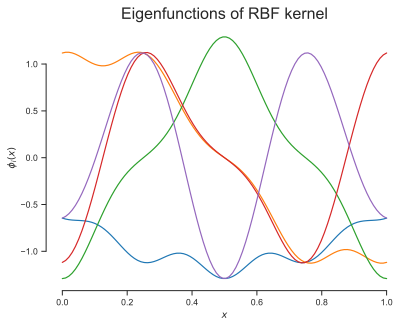

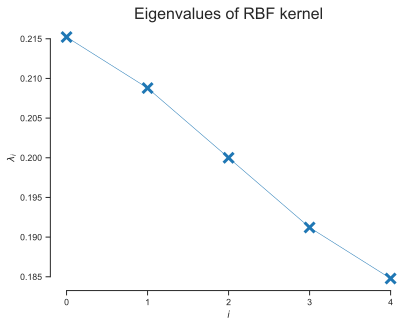

In [6]:
x = jnp.linspace(0, 1, 100)[:, None]

fig, ax = plt.subplots()
ax.plot(x, kle.eval_phi(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi_i(x)$')
ax.set_title('Eigenfunctions of RBF kernel', fontsize=16)
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(kle.lambd, '-x', markersize=10, markeredgewidth=3, lw=0.5)
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$')
ax.set_title('Eigenvalues of RBF kernel', fontsize=16)
ax.set_xticks(range(kle.num_xi))
sns.despine(trim=True);

#### Questions

1. The estimated eigenfunctions and eigenvalues do not look very accurate. Perhaps, you need to increase the number of quadrature points used in the Nystrom approximation. Try ``nq=20``. How do they look now?

2. How are the eigenvalues of the covariance function affected if you decrease the lengthscale?

3. The default variance of the square exponential is one. Try changing it to 2. What changed, if anything?

4. Experiment with different covariance functions, e.g., the ``PoweredExponential`` or the ``Matern32``.

### Varying the lengthscale
Let's vary the lengthscale of the SE and see what happens to the eigenvalues.

In [7]:
lengthscales = [0.01, 0.05, 0.1, 0.2, 0.5]
kles = [build_kle(kernels.ExpSquared(scale=ell), nq=100, alpha=.9, input_dim=1) for ell in lengthscales]

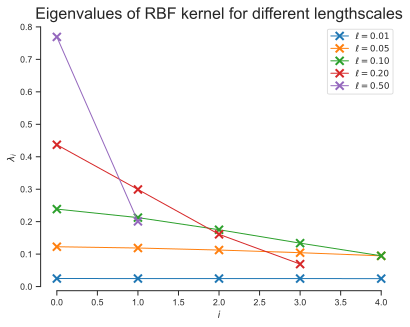

In [8]:
x = jnp.linspace(0, 1, 100)[:, None]
fig, ax = plt.subplots()
for ell, kle in zip(lengthscales, kles):
    ax.plot(kle.lambd[:5], '-x', markersize=8, markeredgewidth=2, lw=1, label='$\ell={0:1.2f}$'.format(ell))
ax.legend(loc='best')
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$')
ax.set_title('Eigenvalues of RBF kernel for different lengthscales', fontsize=16)
sns.despine(trim=True);

#### Questions
1. The larger the lengthscale (and therefore the smoother the GP samples), the faster the eigenvalues decay to zero. **Why?**
*Hint: Think about the RBF eigenfunctions we plotted earlier&mdash;the first was the smoothest, and each subsequent eigenfunction got more "wiggly".*

### Sampling from the random field using $\xi$

Let's plot some samples $f \sim \operatorname{GP}(0, k)$ where $k$ is the *exponential* kernel.

In [9]:
k = kernels.Exp(scale=0.1)  # Exponential kernel. GP samples should look jagged.
kle = build_kle(k, nq=100, alpha=0.8, input_dim=1)

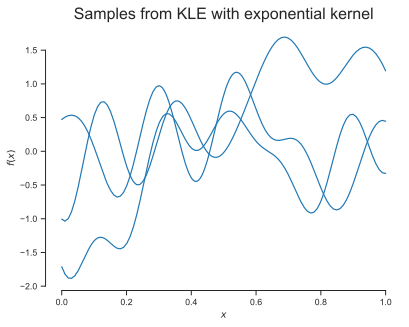

In [10]:
x = jnp.linspace(0, 1, 200)[:, None]
fig, ax = plt.subplots()
for i in range(3):
    key, key_xi = jrandom.split(key)
    xi = jrandom.normal(key_xi, (kle.num_xi,))
    f = kle(x, xi)
    ax.plot(x, f, color=sns.color_palette()[0])
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_title('Samples from KLE with exponential kernel', fontsize=16)
sns.despine(trim=True);

#### Questions
1. Above we show the samples that we get from the KLE using an exponential covariance function.
**They look too smooth.** The samples are supposed to be no-where differentiable. What is the problem?
2. How many terms did you need to get samples that really look like samples from an exponential GP?

### KLE for GP with Observed Data
Here we take a look at the KLE of a GP where we have made some input/output observations

In [11]:
# Just generate some input/output pairs randomly...
key, key_X, key_y = jrandom.split(key, 3)
X = jrandom.uniform(key_X, shape=(3, 1))
y = jrandom.normal(key_y, shape=(3,))

k = kernels.ExpSquared(scale=0.1)
kle = build_kle(k, nq=100, alpha=0.9, Xobs=X, yobs=y, input_dim=1)

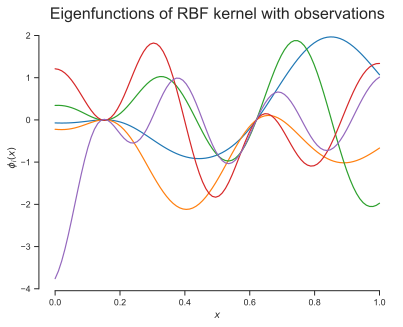

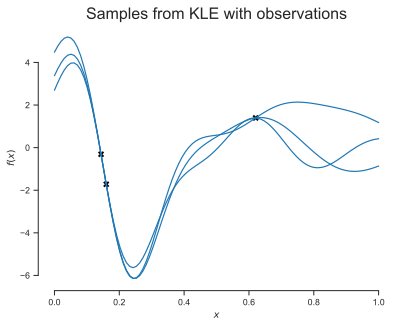

In [12]:
x = jnp.linspace(0, 1, 100)[:, None]
fig, ax = plt.subplots()
ax.plot(x, kle.eval_phi(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi_i(x)$')
ax.set_title('Eigenfunctions of RBF kernel with observations', fontsize=16)
sns.despine(trim=True)

fig, ax = plt.subplots()
ax.plot(X, y, 'kx', markeredgewidth=2)
for i in range(3):
    key, key_xi = jrandom.split(key)
    xi = jrandom.normal(key_xi, (kle.num_xi,))
    f = kle(x, xi)
    ax.plot(x, f, color=sns.color_palette()[0])
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_title('Samples from KLE with observations', fontsize=16)
sns.despine(trim=True);

#### Questions
1. What is the value of the basis functions at the points where we have observations?
2. Experiment with various covariance functions and hyper-parameters.

### Playing in two-dimensions
Let's experiment with these ideas in two dimensions.

In [13]:
WITH_OBSERVATIONS = False  # Set to true to see the eigenfunctions when there are observations.

k = kernels.ExpSquared(scale=0.1)

if WITH_OBSERVATIONS: 
    key, key_X, key_y = jrandom.split(key, 3)
    X = jrandom.uniform(key_X, shape=(10, 2))
    y = jrandom.normal(key_y, shape=(10,))
    kle = build_kle(k, nq=100, alpha=0.9, input_dim=2, Xobs=X, yobs=y)
else:
    kle = build_kle(k, nq=100, alpha=0.9, input_dim=2)

Number of terms: 49


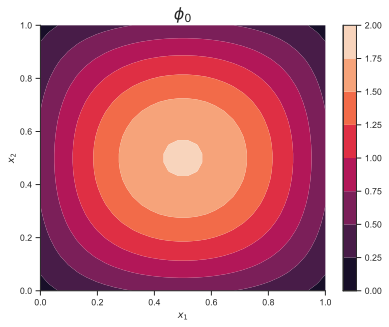

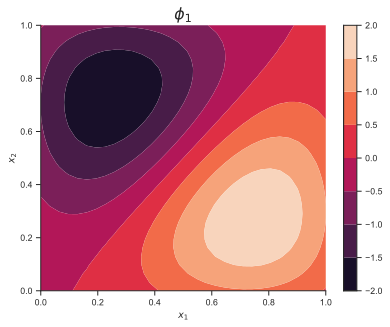

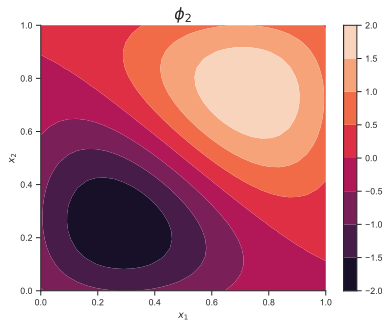

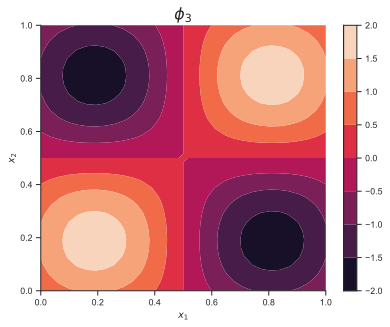

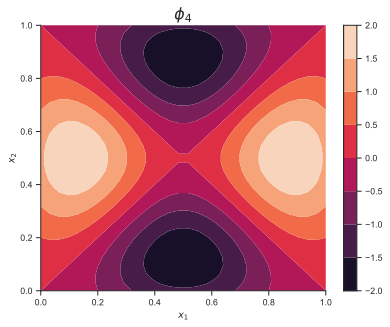

In [14]:
x = jnp.linspace(0, 1, 32)
X1, X2 = jnp.meshgrid(x, x)
X_all = jnp.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print('Number of terms:', kle.num_xi)

# Let's look at them
Phi = kle.eval_phi(X_all)
for i in range(5):
    fig, ax = plt.subplots()
    c = ax.contourf(X1, X2, Phi[:, i].reshape(X1.shape))
    if WITH_OBSERVATIONS:
        ax.plot(X[:, 0], X[:, 1], 'bx', markeredgewidth=2)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(rf'$\phi_{i}$', fontsize=16)
    fig.colorbar(c)
    sns.despine(trim=True);

#### Questions
1. Try plotting some eigenfunctions with higher index.
2. Try adding some observations.
3. Now, that you are getting familar, try to plot a few samples from this random field.